In [ ]:
from google.colab import drive

In [ ]:
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from pathlib import Path

In [ ]:
dir_path = Path('/content/drive/MyDrive/cropped')

In [ ]:
dir_path

PosixPath('/content/drive/MyDrive/cropped')

In [ ]:
image_list = list(dir_path.glob('*/*.jpg'))

In [ ]:
image_list[:5]

[PosixPath('/content/drive/MyDrive/cropped/train/n02085936_10307.jpg'),
 PosixPath('/content/drive/MyDrive/cropped/train/n02085936_126.jpg'),
 PosixPath('/content/drive/MyDrive/cropped/train/n02085620_8637.jpg'),
 PosixPath('/content/drive/MyDrive/cropped/train/n02085782_172.jpg'),
 PosixPath('/content/drive/MyDrive/cropped/train/n02085620_2793.jpg')]

In [ ]:
from PIL import Image
import random

In [ ]:
img = Image.open(random.choice(image_list))
img.width,img.height

(224, 224)

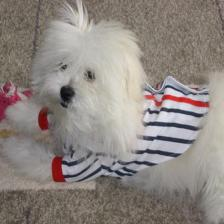

In [ ]:
img

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
img = np.array(img)
img

array([[[102,  92,  82],
        [101,  91,  81],
        [106,  96,  86],
        ...,
        [147, 133, 130],
        [143, 129, 126],
        [145, 131, 128]],

       [[105,  95,  85],
        [115, 105,  95],
        [122, 112, 102],
        ...,
        [131, 117, 114],
        [127, 113, 110],
        [117, 103, 100]],

       [[110, 100,  90],
        [128, 118, 108],
        [135, 125, 115],
        ...,
        [142, 128, 125],
        [143, 129, 126],
        [127, 113, 110]],

       ...,

       [[111, 103,  92],
        [106,  98,  87],
        [117, 109,  98],
        ...,
        [117, 113, 110],
        [121, 117, 114],
        [128, 124, 121]],

       [[ 96,  88,  77],
        [103,  95,  84],
        [116, 108,  97],
        ...,
        [111, 107, 104],
        [113, 109, 106],
        [112, 108, 105]],

       [[105,  97,  86],
        [113, 105,  94],
        [118, 110,  99],
        ...,
        [104, 100,  97],
        [104, 100,  97],
        [ 97,  93,  90]]

(<matplotlib.image.AxesImage at 0x7e9c2dae2ce0>, (224, 224, 3))

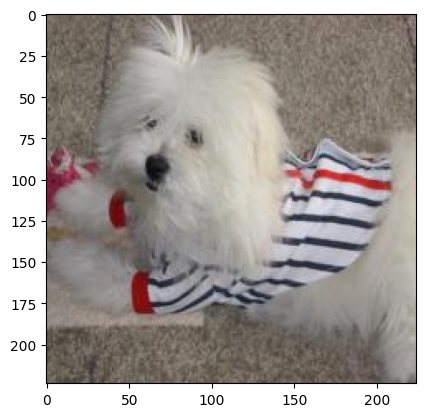

In [ ]:
plt.imshow(img),img.shape

In [ ]:
def plot_img(image_list:list):
    img = Image.open(random.choice(image_list))
    print(f"height: {img.height}\nwidth :{img.width}")
    img = np.array(img)
    plt.imshow(img)
    plt.show()

height: 224
width :224


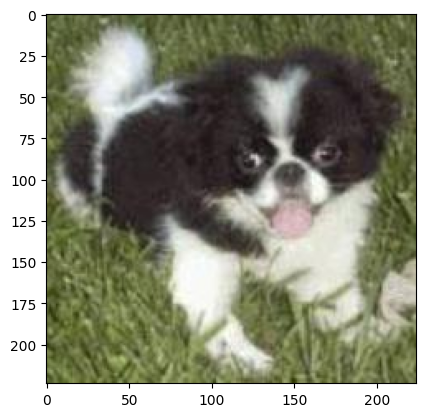

In [ ]:
plot_img(image_list)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(15),  # Rotate images by up to 15 degrees
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Mean values for each channel
                         #std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'

In [ ]:
def plot_transforms(image_list:list):
    img = Image.open(random.choice(image_list))
    transformed = train_transforms(img).permute(1,2,0)
    plt.imshow(transformed)


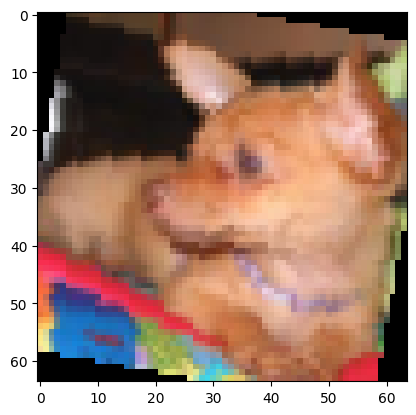

In [ ]:
plot_transforms(image_list)

In [ ]:
def plot_difference(image_list=image_list,transform=train_transforms):
    img = Image.open(random.choice(image_list))
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[0].set_title(f'original')
    transformed = transform(img)
    ax[1].imshow(transformed.permute(1,2,0))
    ax[1].set_title(f'transformed')

In [ ]:
num = 5

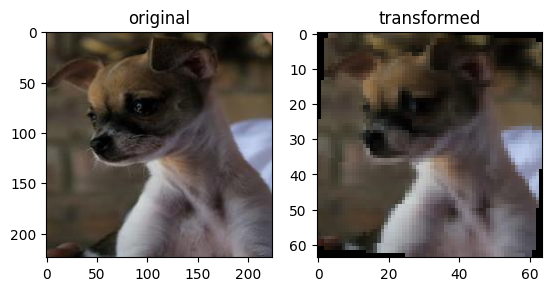

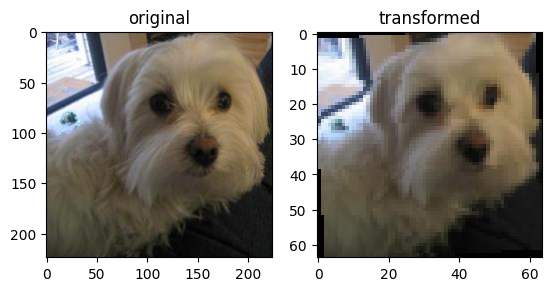

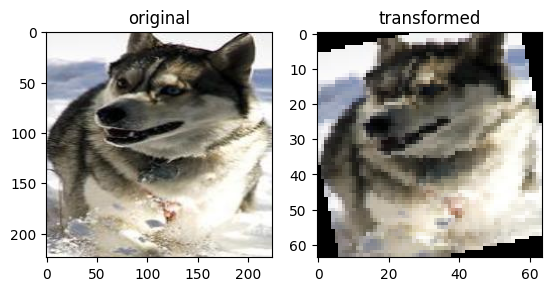

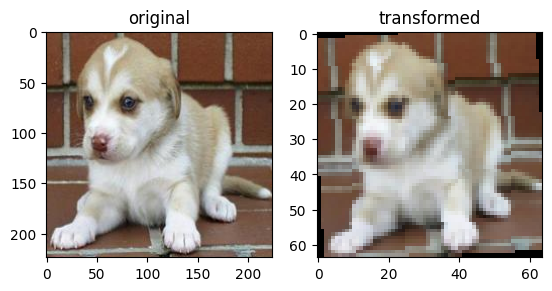

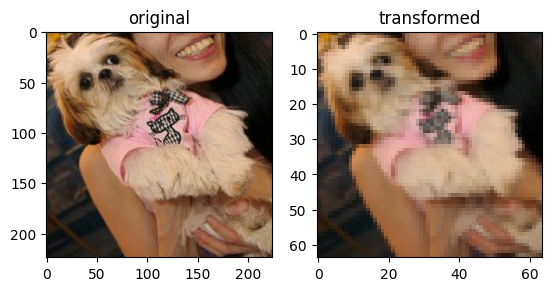

In [ ]:
for i in range(num):
    plot_difference()

In [ ]:
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset

In [ ]:
class DOGDATASET(Dataset):
  def __init__(self,dir_path,transform=None):
    super().__init__()
    self.path = list(Path(dir_path).glob('*.jpg'))
    self.transform = transform

  def __len__(self):
    return len(self.path)

  def load_image(self,index):
    self.img = self.path[index]
    return Image.open(self.img)

  def __getitem__(self,index):
    image = self.load_image(index)
    if self.transform:
      return self.transform(image)
    else:
      return image



In [ ]:
train_data = DOGDATASET(dir_path=train_dir,transform=train_transforms)
test_data = DOGDATASET(dir_path=test_dir,transform=test_transforms)

In [ ]:
train_data,test_data

(<__main__.DOGDATASET at 0x7e9c2dca9720>,
 <__main__.DOGDATASET at 0x7e9c2d9e3940>)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
bs = 8

In [ ]:
train_loader = DataLoader(dataset=train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=bs,shuffle=False)

In [ ]:
train_loader,test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e9c462004f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e9c46200970>)

In [ ]:
sample = next(iter(train_data))
sample.shape

torch.Size([3, 64, 64])

In [ ]:
len(train_loader),len(test_loader)

(88, 60)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,latent_dim):
    super().__init__()

    self.conv1 = nn.Conv2d(
        in_channels=3,
        out_channels=32,
        kernel_size=4,
        stride=1,
    )
    self.conv2 = nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=4,
        stride=1,
    )
    self.relu = nn.ReLU()
    self.fc_mu = nn.Linear(215296,latent_dim)
    self.fc_logvar = nn.Linear(215296,latent_dim)
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    #x = self.conv3(x)
    #x = self.relu(x)
    x = x.view(x.size(0),-1)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu,logvar

In [ ]:
z_dim = 200

In [ ]:
encoder = Encoder(latent_dim=z_dim).to(device)

OutOfMemoryError: ignored

In [ ]:
sample = torch.randn(8,3,64,64)

In [ ]:
mu,logvar = encoder(sample.to(device))
len(mu),len(logvar)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
sample.shape

In [ ]:
summary(model=encoder,input_size=[8,3,64,64])

In [ ]:
class Decoder(nn.Module):
  def __init__(self,latent_dim):
    super().__init__()
    self.fc = nn.Linear(latent_dim,64*58*58)
    self.deconv1 = nn.ConvTranspose2d(
        in_channels=64,
        out_channels=32,
        kernel_size=4,
        stride=1
    )
    self.deconv2 = nn.ConvTranspose2d(
        in_channels=32,
        out_channels=3,
        kernel_size=4,
        stride=1
    )
    self.relu = nn.ReLU()
  def forward(self,z):
    x = self.fc(z)
    x = x.view(x.size(0),64,58,58)
    x = self.relu(x)
    x = self.deconv1(x)
    x = self.relu(x)
    x = torch.sigmoid(self.deconv2(x))
    return x


In [ ]:
decoder = Decoder(z_dim).to(device)

In [ ]:
d_sample = torch.randn(8,z_dim)

In [ ]:
output = decoder(d_sample.to(device))

In [ ]:
summary(model=decoder,input_size=[8,200])

In [ ]:
class VAE(nn.Module):
  def __init__(self,latent_dim):
    super().__init__()
    self.encoder = Encoder(latent_dim).to(device)
    self.decoder = Decoder(latent_dim).to(device)

  def reparameterize(self,mu,logvar):
    eps = torch.randn_like(logvar)
    z = mu + eps * torch.exp(0.5 * logvar)
    return z
  def forward(self,x):
    mu,logvar = self.encoder(x)
    z = self.reparameterize(mu,logvar)
    x_hat = self.decoder(z)
    return x_hat,mu,logvar


In [ ]:
model = VAE(z_dim).to(device)

In [ ]:
a,b,c= model(sample.to(device))

In [ ]:
summary(model=model,input_size=[8,3,64,64])

In [ ]:
model.state_dict()

In [ ]:
sample_data = torch.randn(1,3,64,64)

In [ ]:
model.eval()
with torch.no_grad():
  a,b,c = model(sample_data.to(device))

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(sample_data.squeeze().permute(1,2,0))
ax[1].imshow(a.squeeze().permute(1,2,0).cpu())


In [ ]:
images = next(iter(train_loader))

In [ ]:
a,b,c = model(images.to(device))

In [ ]:
def loss_fn(recon_x,x,mu,logvar):
  reconstruction_loss = nn.MSELoss(reduction='sum')(recon_x,x)
  #print(reconstruction_loss)
  kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  #print(kl_divergence)
  return reconstruction_loss * 10000 + kl_divergence

In [ ]:
loss_fn(images.to(device),a.to(device),b.to(device),c.to(device))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0002)

In [ ]:
def train_step(model=model,
               dataloader=train_loader,
               lossfn=loss_fn,
               optimizer=optimizer,
               device=device):
  model.train()
  train_loss = 0
  for X in dataloader:
    X = X.to(device)
    optimizer.zero_grad()
    recon_x,mu,logvar = model(X)
    loss = loss_fn(recon_x,X,mu,logvar)
    train_loss = train_loss + loss
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  return train_loss

In [ ]:
def test_step(model=model,
              dataloader=test_loader,
              loss_fn=loss_fn,
              device=device):
  model.eval()
  test_loss = 0
  for X in dataloader:
    X = X.to(device)
    recon_x,mu,logvar = model(X)
    loss = loss_fn(recon_x,X,mu,logvar)
    test_loss += loss
  test_loss /= len(dataloader)
  return test_loss

In [ ]:
epochs = 50

In [ ]:
for epoch in range(epochs):
  train_loss = train_step()
  test_loss = test_step()
  print(f"epoch: {epoch} | train loss: {train_loss} | test loss: {test_loss}")
  if test_loss < 5000000:
    break

In [ ]:
model.eval()
x = train_data[3]
x = x.unsqueeze(dim=0)
with torch.no_grad():
  z,a,b = model(x.to(device))

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(x.squeeze().permute(1,2,0))
ax[1].imshow(z.squeeze().permute(1,2,0).cpu())


In [ ]:
def plot_output(train_data):
  model.eval()
  x = random.choice(train_data)
  x = x.unsqueeze(dim=0)
  with torch.no_grad():
    z,a,b = model(x.to(device))
  fig,ax = plt.subplots(1,2)
  ax[0].imshow(x.squeeze().permute(1,2,0))
  ax[1].imshow(z.squeeze().permute(1,2,0).cpu())



In [ ]:
for i in range(5):
  plot_output(train_data)


In [ ]:
for i in range(5):
  plot_output(test_data)


In [ ]:
img = Image.open('/content/GettyImages-1170243723.jpg')
img = test_transforms(img)
img

In [ ]:
model.eval()
with torch.no_grad():
  result,a,b = model(img.unsqueeze(dim=0).to(device))

In [ ]:
img.shape

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img.squeeze().permute(1,2,0))
ax[1].imshow(result.squeeze().permute(1,2,0).cpu())